In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def select_bic(X, patiency):
    X = X.sort_values('iteration p')
    best_p = 0
    best_bic = np.inf
    no_imp = 0
    for _, x in X.iterrows():
        if x['bic'] < best_bic:
            best_bic = x['bic']
            best_p = x['iteration p']
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patiency:
                break
    return X[X['iteration p']==best_p]
    
def select_best(results, method, patiency=1):
    method_results = results[results['method']==method]
    best_iteration_p = method_results.groupby(['p', 'run']).apply(select_bic, patiency).reset_index(drop=True)
    return best_iteration_p

def select_best_dim(results, method, patiency=1):
    method_results = results[results['method']==method]
    best_iteration_p = method_results.groupby(['dimensions', 'run']).apply(select_bic, patiency).reset_index(drop=True)
    return best_iteration_p

def results_runtime(results, method, patience):
    best = select_best(results, method, patience)
    best['runtime'] = 0
    for idx, b in best.iterrows():
        best.loc[idx, 'runtime'] = results.loc[(results['p']==b['p']) & 
                                               (results['method']==method) &
                                               (results['run']==b['run']) & 
                                               (results['iteration p']<=b['iteration p']), 'time'].sum()
    return best

def results_runtime_dim(results, method, patience):
    best = select_best_dim(results, method, patience)
    best['runtime'] = 0
    for idx, b in best.iterrows():
        best.loc[idx, 'runtime'] = results.loc[(results['dimensions']==b['dimensions']) & 
                                               (results['method']==method) &
                                               (results['run']==b['run']) & 
                                               (results['iteration p']<=b['iteration p']), 'time'].sum()
    return best

### p estimation: time lag

/home/ci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/ci/.local/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/ci/.local/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


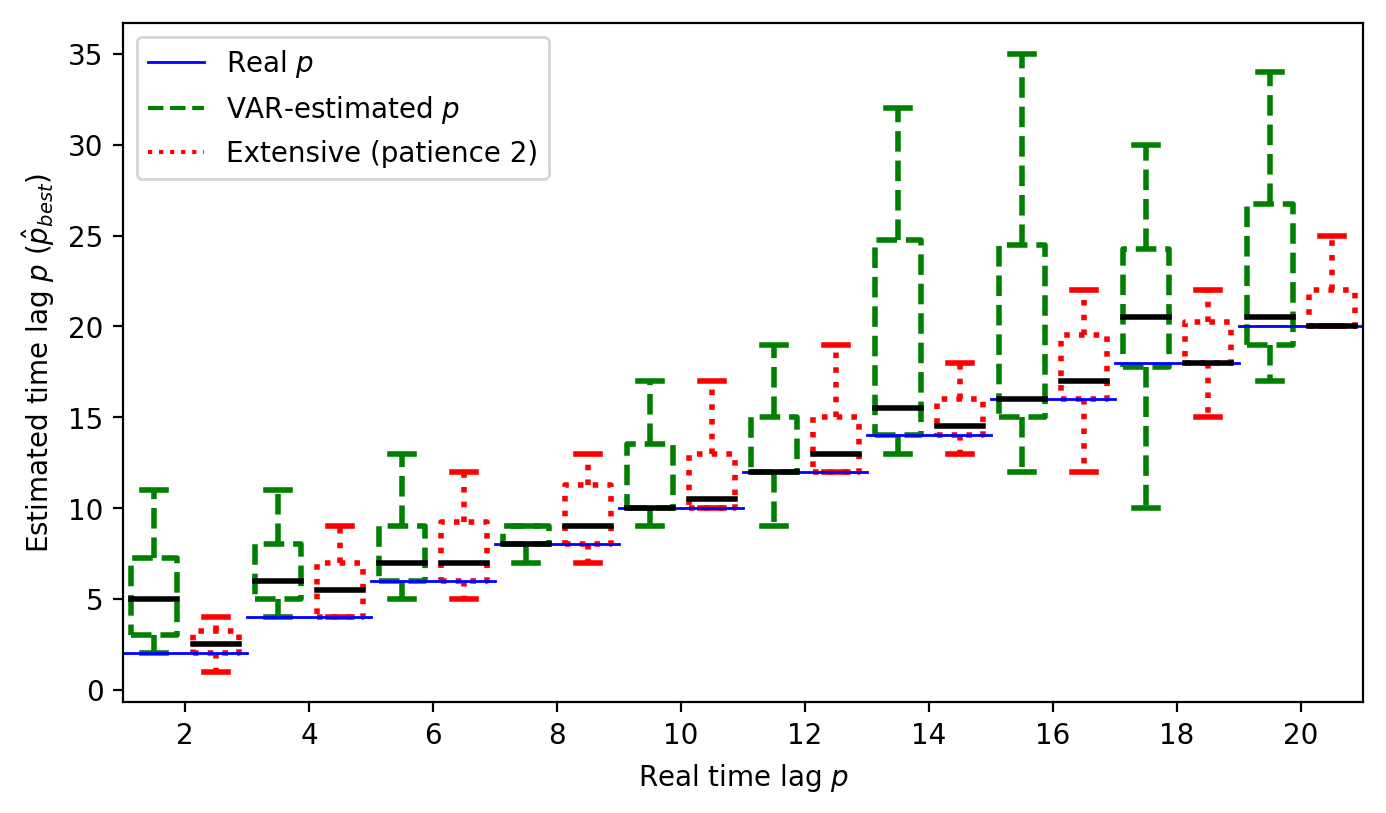

In [7]:
results = pd.read_csv('results/iterations/result.csv')
comp_results = pd.read_csv('results/iterations/comp_result.csv')

def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='green', linestyle='--', linewidth=2)
    plt.setp(bp['caps'][0], color='green', linewidth=2)
    plt.setp(bp['caps'][1], color='green', linewidth=2)
    plt.setp(bp['whiskers'][0], color='green', linestyle='--', linewidth=2)
    plt.setp(bp['whiskers'][1], color='green', linestyle='--', linewidth=2)
#     plt.setp(bp['fliers'][1], color='green')
    plt.setp(bp['medians'][0], color='black', linewidth=2)
    
    plt.setp(bp['boxes'][1], color='red', linestyle=':', linewidth=2)
    plt.setp(bp['caps'][2], color='red', linewidth=2)
    plt.setp(bp['caps'][3], color='red', linewidth=2)
    plt.setp(bp['whiskers'][2], color='red', linestyle=':', linewidth=2)
    plt.setp(bp['whiskers'][3], color='red', linestyle=':', linewidth=2)
#     plt.setp(bp['fliers'][2], color='red')
    plt.setp(bp['medians'][1], color='black', linewidth=2)

ps = list(range(2,22,2))
approaches = {
    'extensive': select_best(results, 'extensive', 2).groupby('p')['iteration p'],
    'bic': comp_results[comp_results['method']=='bic'].groupby('p')['iteration p']
}

boxplot_data = dict((p, {}) for p in ps)
for approach_name, values in approaches.items():
    for group, df in values:
        boxplot_data[group][approach_name] = df

fig = plt.figure(dpi=200, figsize=(8,4.5))
ax = plt.axes()
plt.hold(True)
for p, data in boxplot_data.items():
    arr = [data['bic'], data['extensive']]
    bp = plt.boxplot(arr, positions=[ps.index(p)*4+1, ps.index(p)*4+3], widths=1.5, showfliers=False)
    setBoxColors(bp)
ax.set_xticklabels(ps)
ax.set_xticks(4*np.arange(len(ps))+2)

# draw temporary red and blue lines and use them to create a legend
b, = plt.plot([1,1], color='green', linestyle='--')
c, = plt.plot([1,1], color='red', linestyle=':')

eps = np.finfo(np.float32).eps
real_idx = np.array([[4*i-0.5, 4*i-0.5+eps, 4*(i+1)-0.5-eps, 4*(i+1)-0.5] for i in range(len(ps))]).flatten() + .5
real_val = np.array([[np.nan, p, p, np.nan] for p in ps]).flatten()
d, = plt.plot(real_idx, real_val, 'b', linewidth=1)

plt.legend((d, b, c),(r'Real $p$', r'VAR-estimated $p$', 'Extensive (patience 2)'))
b.set_visible(False)
c.set_visible(False)

plt.xlim(0, 40)
plt.xlabel(r'Real time lag $p$')
plt.ylabel(r'Estimated time lag $p$ ($\hat{p}_{best}$)')
# plt.title('p estimation')

plt.show()

### $F_1$ score: time lag

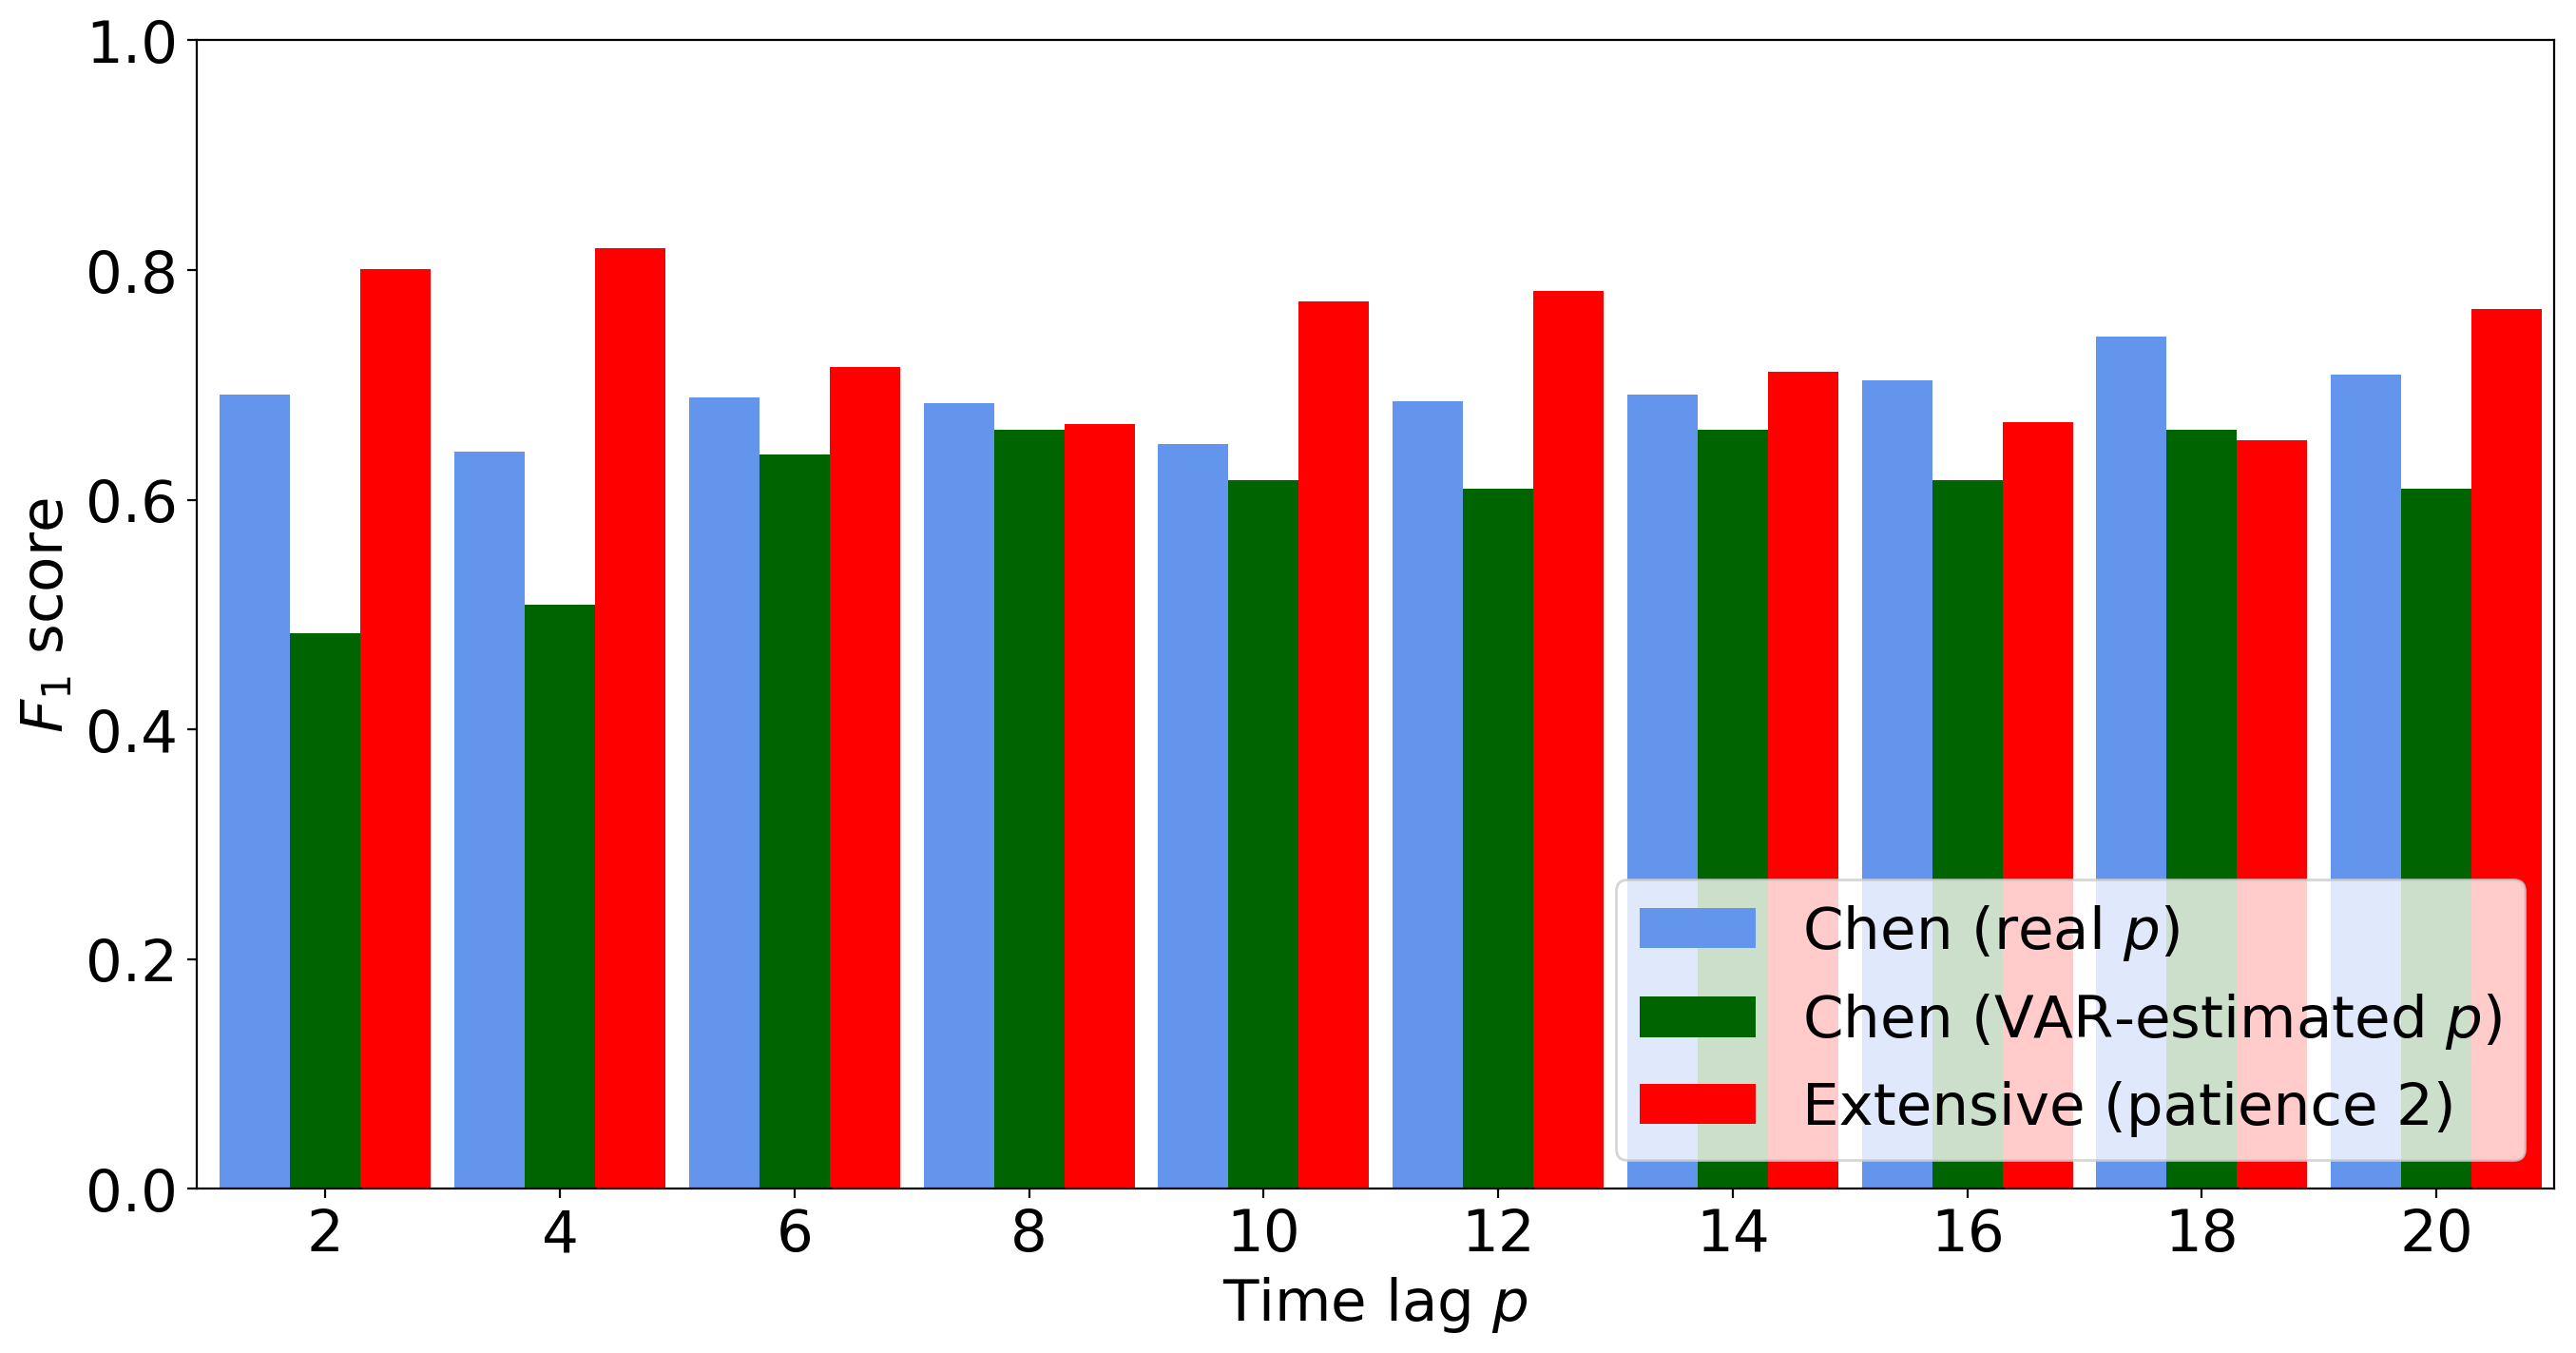

In [8]:
ps = np.arange(2,22,2)
approaches = {
    r'Chen (real $p$)': (0, 'cornflowerblue', comp_results[comp_results['method']=='real'].groupby('p')['f1'].mean(), ''),
    r'Chen (VAR-estimated $p$)': (1, 'darkgreen', comp_results[comp_results['method']=='bic'].groupby('p')['f1'].mean(), ''),
    'Extensive (patience 2)': (2, 'red', select_best(results, 'extensive', 2).groupby('p')['f1'].mean(), '')
}

width=0.3
margin=0.1
plt.figure(dpi=200, figsize=(16,8))
# plt.title(r'$F_1$ score comparison', fontsize=22)
plt.xlabel(r'Time lag $p$', fontsize=22)
plt.ylabel(r'$F_1$ score', fontsize=22)
for name, (index, color, values, hatch) in approaches.items():
    plt.bar(np.arange(len(ps)) + index*width, values, width=width, label=f'{name}', color=color, hatch=hatch)

plt.xticks(np.arange(len(ps))+width, ps, fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(-0.5*width-margin, len(ps)-1*width+margin)
plt.ylim(0,1)
plt.legend(loc=4, fontsize=22)
plt.show()

### Runtime: timelag

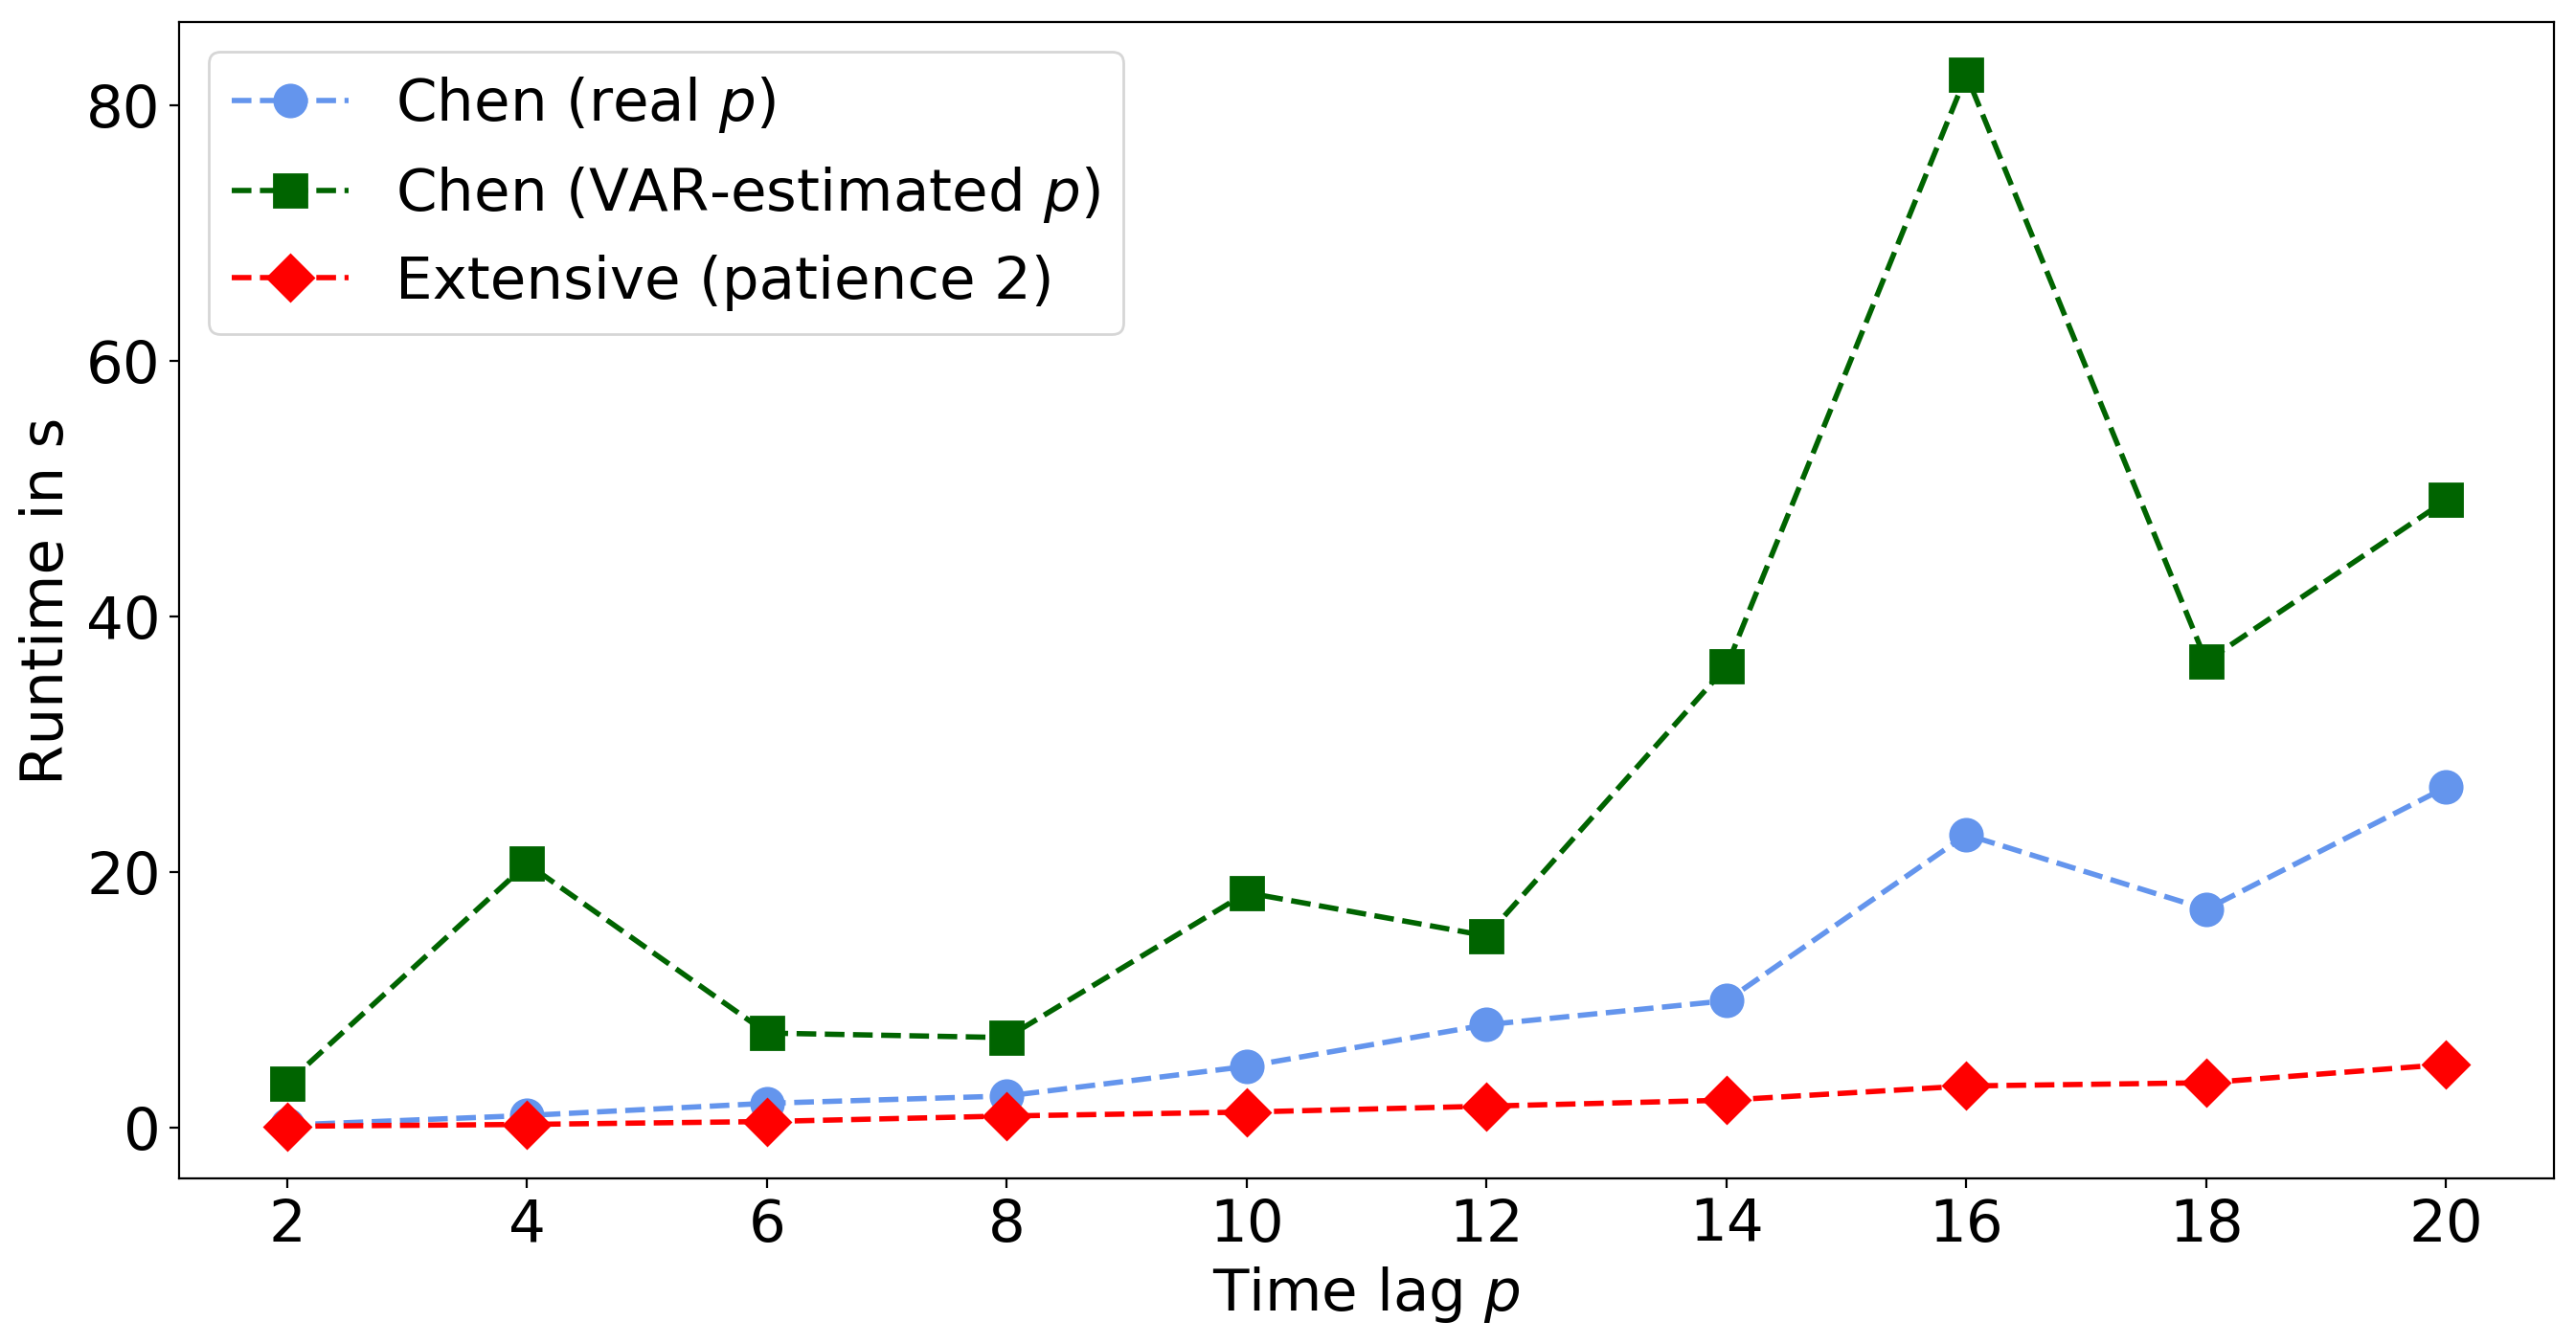

In [9]:
mean_runtime = {r'Chen (real $p$)': ('cornflowerblue', 
                                  comp_results[comp_results['method']=='real'].groupby(['p'])['time'].mean(),
                                  'o', '--'),
                r'Chen (VAR-estimated $p$)': ('darkgreen', 
                                           comp_results[comp_results['method']=='bic'].groupby(['p'])['time'].mean(),
                                           's', '--'),
                'Extensive (patience 2)': ('red', 
                                           results_runtime(results, 'extensive', 2).groupby(['p'])['runtime'].mean(),
                                           'D', '--')
}


plt.figure(dpi=200, figsize=(16,8))

for name, (color, data, marker, linestyle) in mean_runtime.items():
    plt.plot(data.index, data, color=color, marker=marker, linestyle=linestyle, 
             label=name, linewidth=2, markersize=12)

plt.yscale('linear')
plt.xticks(np.arange(2, 22, 2), np.arange(2, 22, 2), fontsize=22)
plt.yticks(fontsize=22)
# plt.title('Runtime for different p', fontsize=22)
plt.xlabel(r'Time lag $p$', fontsize=22)
plt.ylabel('Runtime in s', fontsize=22)
plt.legend(fontsize=22)
plt.show()

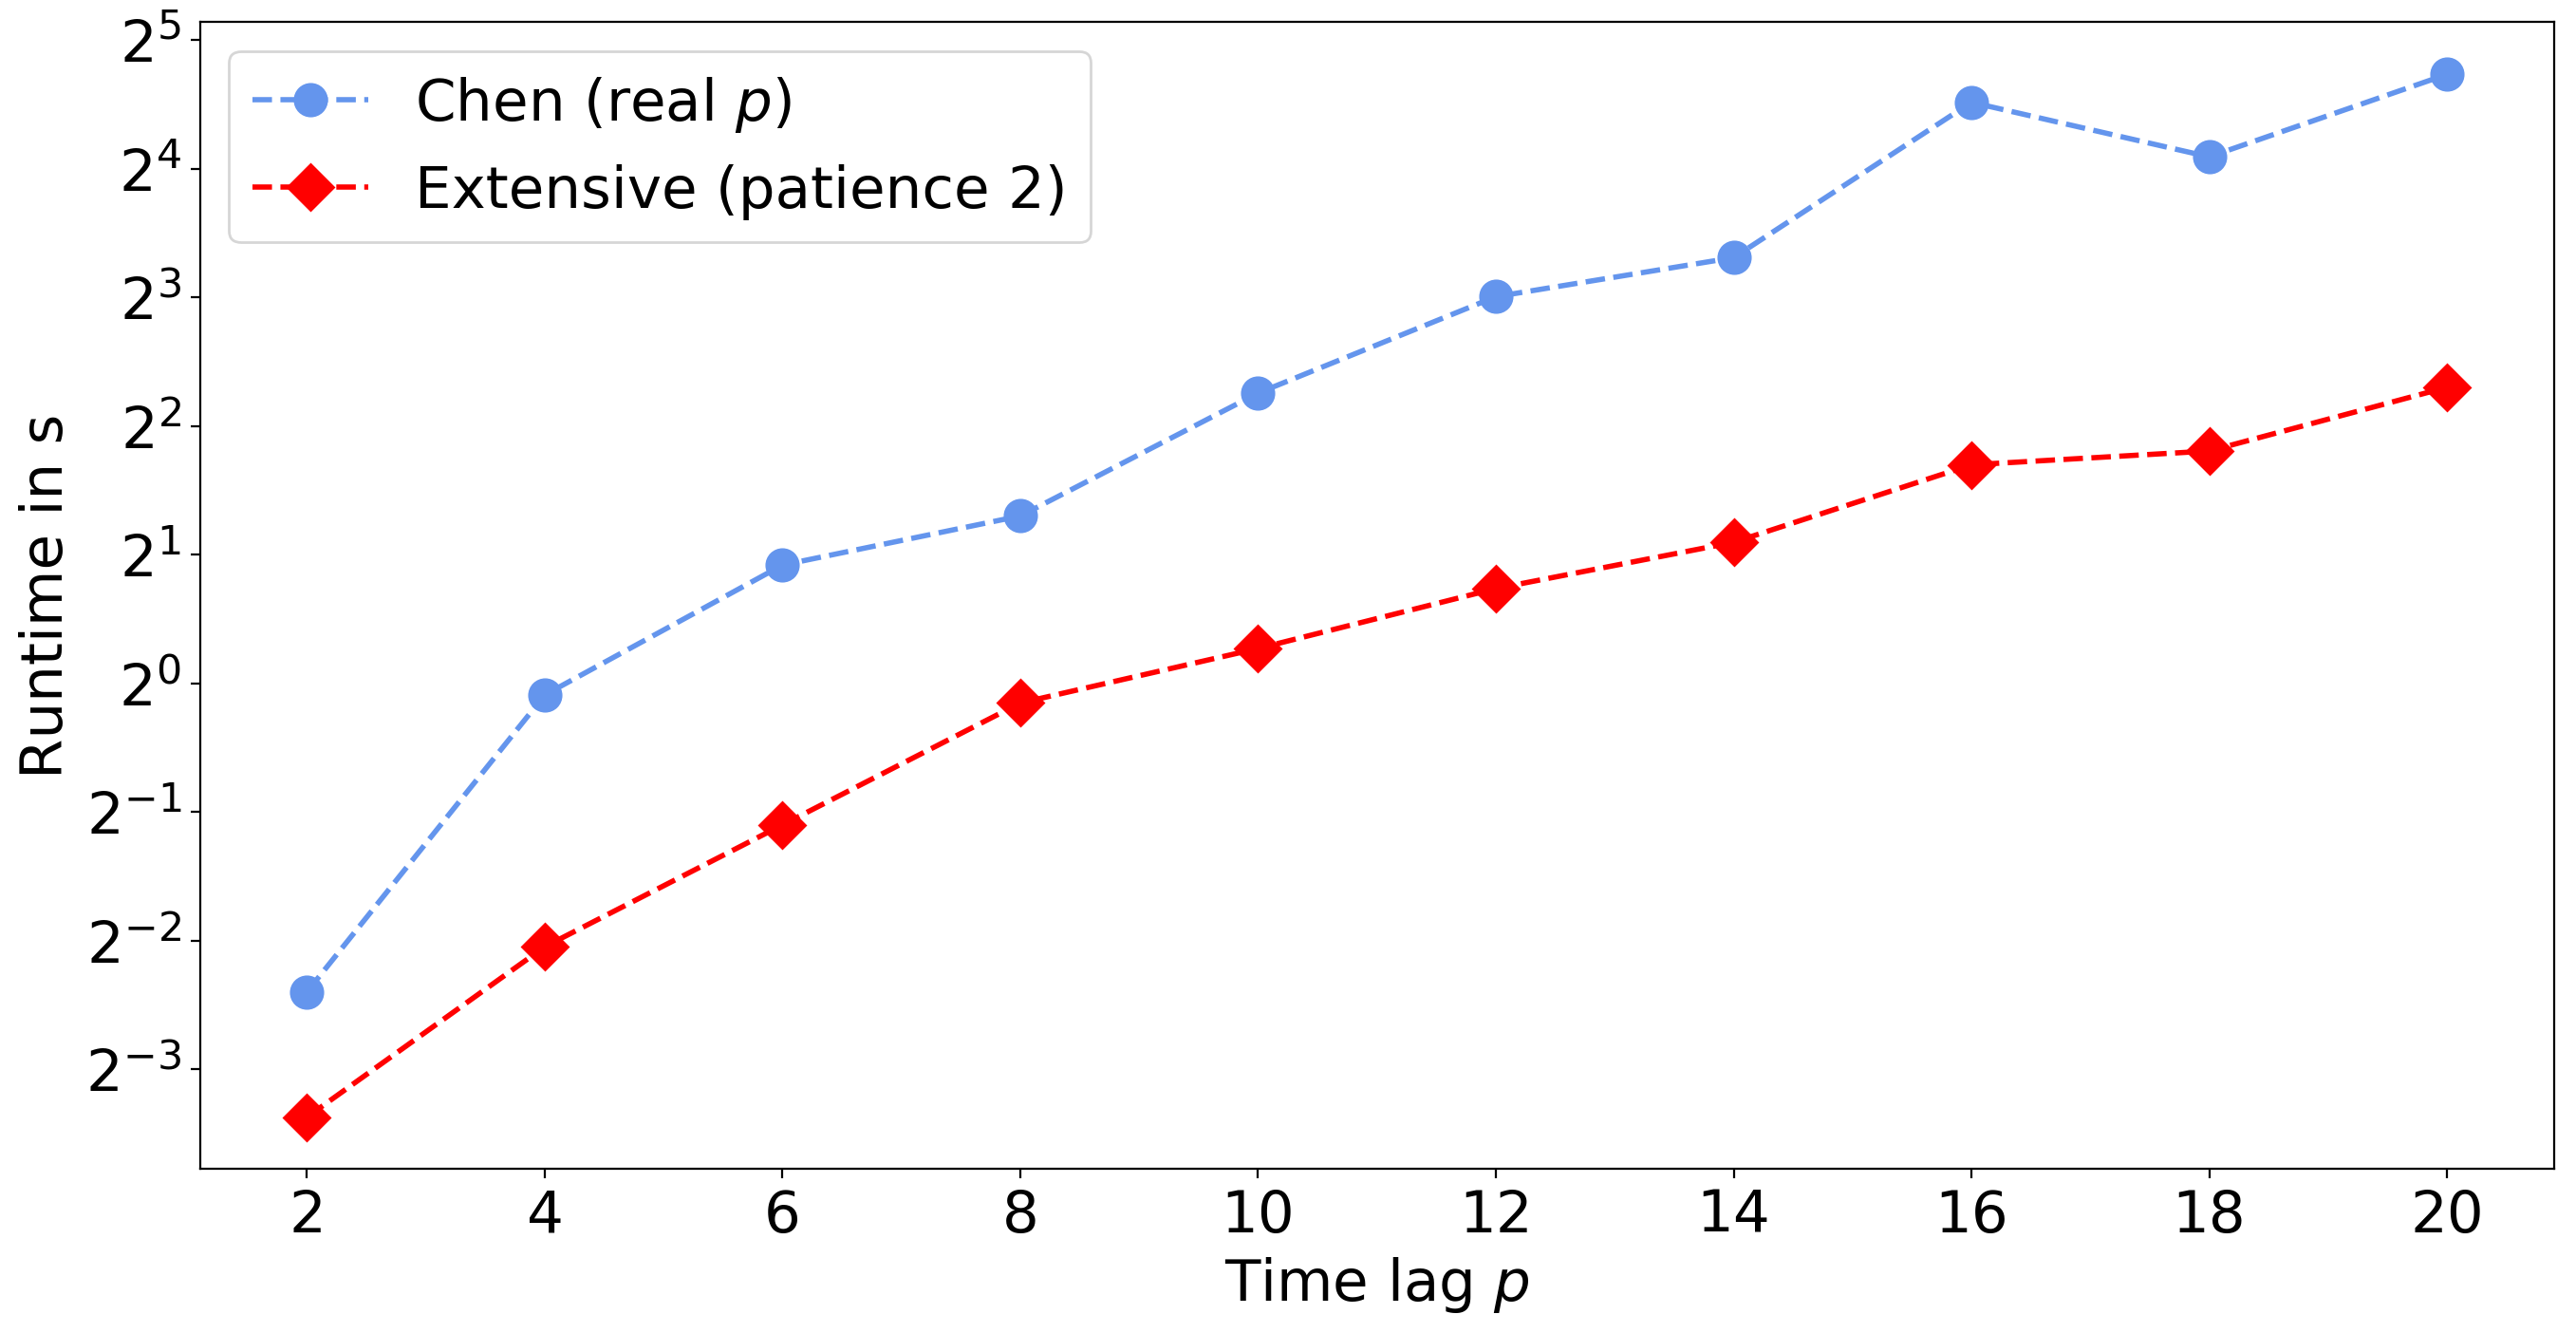

In [10]:
mean_runtime = {r'Chen (real $p$)': ('cornflowerblue', 
                                  comp_results[comp_results['method']=='real'].groupby(['p'])['time'].mean(),
                                  'o', '--'),
                'Extensive (patience 2)': ('red', 
                                           results_runtime(results, 'extensive', 2).groupby(['p'])['runtime'].mean(),
                                           'D', '--')
}


plt.figure(dpi=200, figsize=(16,8))

for name, (color, data, marker, linestyle) in mean_runtime.items():
    plt.plot(data.index, data, color=color, marker=marker, linestyle=linestyle, 
             label=name, linewidth=2, markersize=12)

plt.yscale('log', basey=2)
plt.xticks(np.arange(2, 22, 2), np.arange(2, 22, 2),fontsize=22)
plt.yticks(fontsize=22)
# plt.title('Runtime on log scale for different p', fontsize=22)
plt.xlabel(r'Time lag $p$', fontsize=22)
plt.ylabel('Runtime in s', fontsize=22)
plt.legend(fontsize=22)
plt.show()

### Conditions: time lag

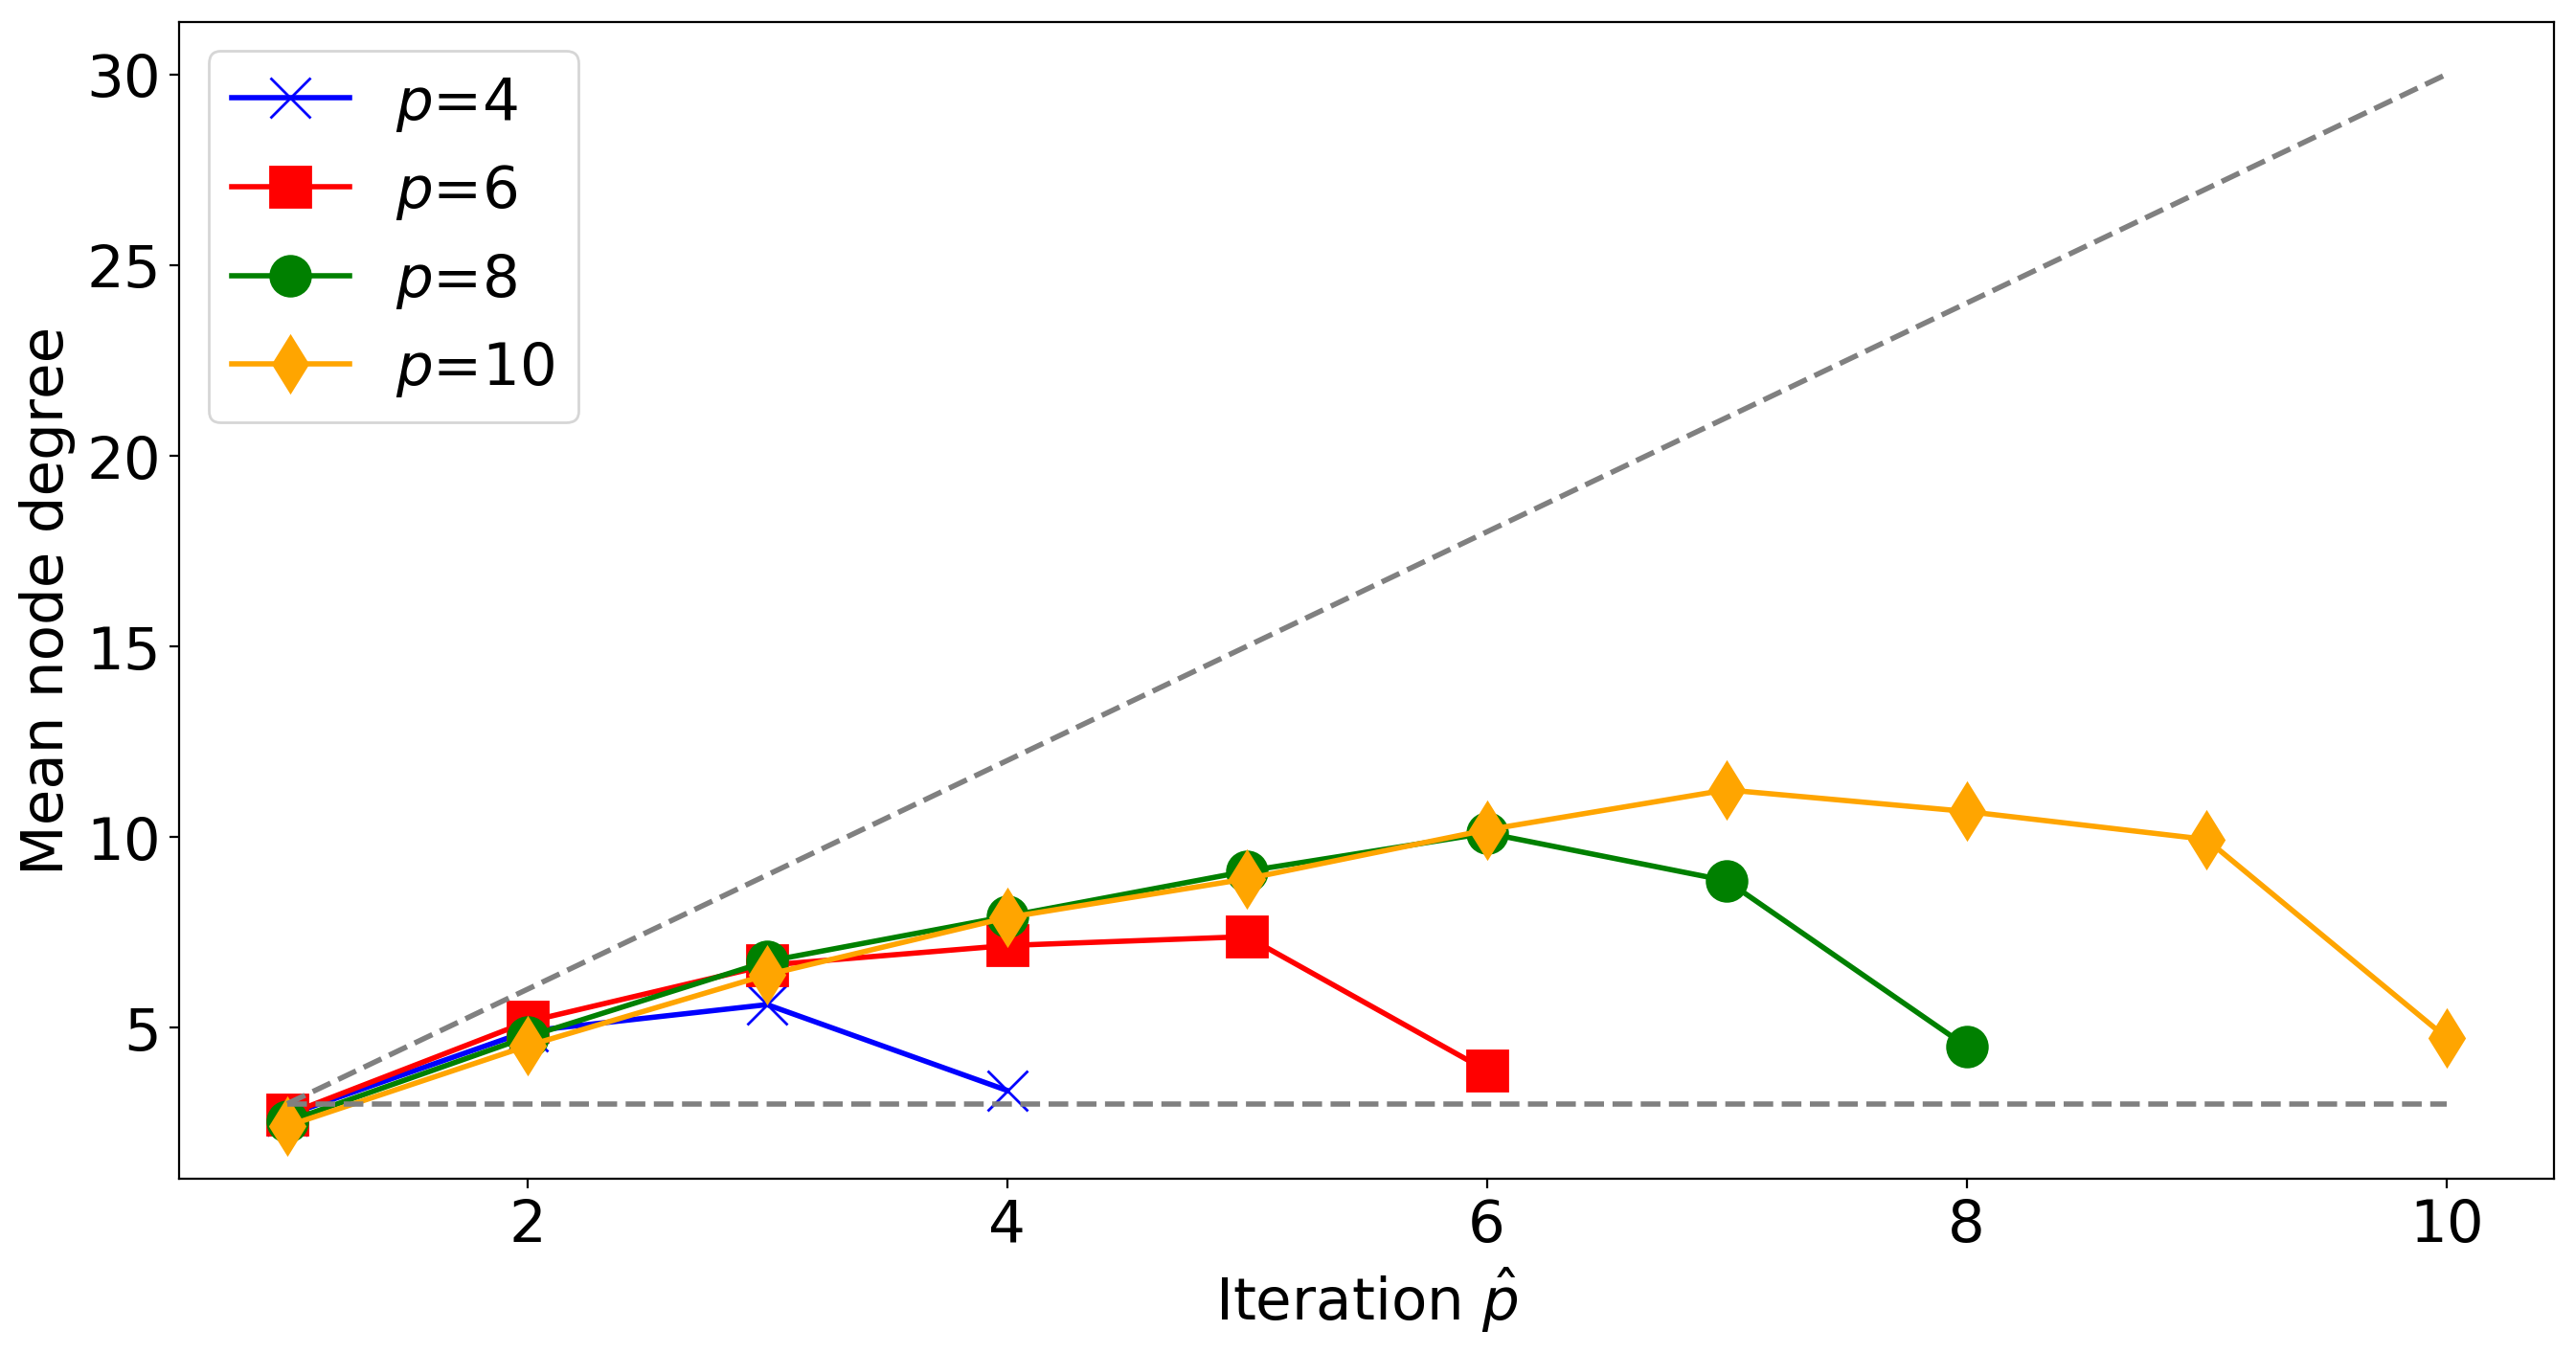

In [13]:
max_p = 10
neighbors = pd.read_csv('results/iterations/neighborhoods.csv')
selection = (neighbors['method']=='extensive')&(neighbors['p'] <= max_p)&(neighbors['p'] >= neighbors['iteration p'])
agg_neighbors = neighbors[selection].groupby(['p', 'iteration p'])[['X0', 'X1', 'X2']].mean().reset_index()

mean_degrees = {r'$p$=4': (agg_neighbors.loc[agg_neighbors['p']==4, 'iteration p'],
                       agg_neighbors.loc[agg_neighbors['p']==4, ['X0', 'X1', 'X2']].mean(1),
                       'blue', 'x'),
               r'$p$=6': (agg_neighbors.loc[agg_neighbors['p']==6, 'iteration p'],
                       agg_neighbors.loc[agg_neighbors['p']==6, ['X0', 'X1', 'X2']].mean(1),
                       'red', 's'),
               r'$p$=8': (agg_neighbors.loc[agg_neighbors['p']==8, 'iteration p'],
                       agg_neighbors.loc[agg_neighbors['p']==8, ['X0', 'X1', 'X2']].mean(1),
                       'green', 'o'),
               r'$p$=10': (agg_neighbors.loc[agg_neighbors['p']==10, 'iteration p'],
                       agg_neighbors.loc[agg_neighbors['p']==10, ['X0', 'X1', 'X2']].mean(1),
                       'orange', 'd'),
                
    
}


plt.figure(dpi=200, figsize=(16, 8))
for name, (x, y, color, marker) in mean_degrees.items():
    plt.plot(x, y, label=name, color=color, marker=marker, linewidth=2, markersize=15)

plt.xlabel(r'Iteration $\hat{p}$', fontsize=22)
plt.ylabel('Mean node degree', fontsize=22)
# plt.title('Mean degree for different p', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.plot(np.arange(1, max_p+1), np.full(max_p, 3), c='grey', linestyle='--', linewidth=2)
plt.plot(np.arange(1, max_p+1), np.arange(1, max_p+1)*3, c='grey', linestyle='--', linewidth=2)    
plt.legend(fontsize=22)
plt.show()

### p estimation: dimensions

/home/ci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/ci/.local/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/ci/.local/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


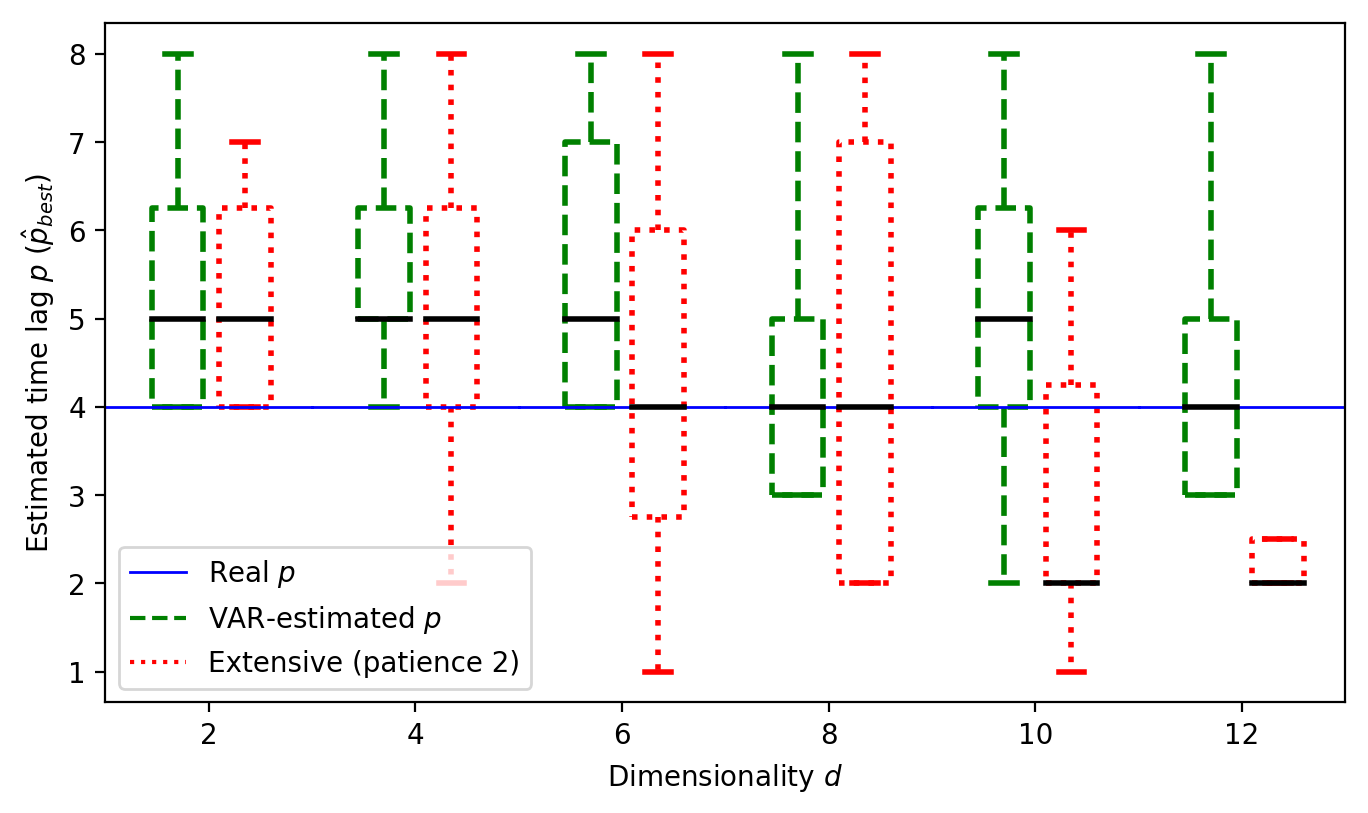

In [21]:
results_dim = pd.read_csv('results/iterations/result_dimensions.csv')
comp_results_dim = pd.read_csv('results/iterations/comp_result_dimensions.csv')

def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='green', linestyle='--', linewidth=2)
    plt.setp(bp['caps'][0], color='green', linewidth=2)
    plt.setp(bp['caps'][1], color='green', linewidth=2)
    plt.setp(bp['whiskers'][0], color='green', linestyle='--', linewidth=2)
    plt.setp(bp['whiskers'][1], color='green', linestyle='--', linewidth=2)
#     plt.setp(bp['fliers'][1], color='green')
    plt.setp(bp['medians'][0], color='black', linewidth=2)
    
    plt.setp(bp['boxes'][1], color='red', linestyle=':', linewidth=2)
    plt.setp(bp['caps'][2], color='red', linewidth=2)
    plt.setp(bp['caps'][3], color='red', linewidth=2)
    plt.setp(bp['whiskers'][2], color='red', linestyle=':', linewidth=2)
    plt.setp(bp['whiskers'][3], color='red', linestyle=':', linewidth=2)
#     plt.setp(bp['fliers'][2], color='red')
    plt.setp(bp['medians'][1], color='black', linewidth=2)

dims = list(range(2,14,2))
approaches = {
    'extensive': select_best_dim(results_dim, 'extensive', 2).groupby('dimensions')['iteration p'],
    'bic': comp_results_dim[comp_results_dim['method']=='bic'].groupby('dimensions')['iteration p']
}

boxplot_data = dict((dim, {}) for dim in dims)
for approach_name, values in approaches.items():
    for group, df in values:
        if group not in dims:
            continue
        boxplot_data[group][approach_name] = df

fig = plt.figure(dpi=200, figsize=(8,4.5))
ax = plt.axes()
plt.hold(True)

for dim, data in boxplot_data.items():
    arr = [data['bic'], data['extensive']]
    bp = plt.boxplot(arr, positions=[dims.index(dim)*4+1.4, dims.index(dim)*4+2.7],
                     widths=1, showfliers=False)
    setBoxColors(bp)
ax.set_xticklabels(dims)
ax.set_xticks(4*np.arange(len(dims))+2)

# draw temporary red and blue lines and use them to create a legend
b, = plt.plot([1,1], color='green', linestyle='--')
c, = plt.plot([1,1], color='red', linestyle=':')

eps = np.finfo(np.float32).eps
real_idx = np.array([[4*i-0.5, 4*i-0.5+eps, 4*(i+1)-0.5-eps, 4*(i+1)-0.5] for i in range(len(dims))]).flatten() + .5
real_val = np.array([[np.nan, 4, 4, np.nan] for dim in dims]).flatten()
d, = plt.plot(real_idx, real_val, 'b', linewidth=1)

plt.legend((d, b, c),(r'Real $p$', r'VAR-estimated $p$', 'Extensive (patience 2)'))
b.set_visible(False)
c.set_visible(False)

plt.xlim(0, 24)
plt.xlabel(r'Dimensionality $d$')
plt.ylabel(r'Estimated time lag $p$ ($\hat{p}_{best}$)')
# plt.title('p estimation')

plt.show()

### $F_1$ score: dimensions

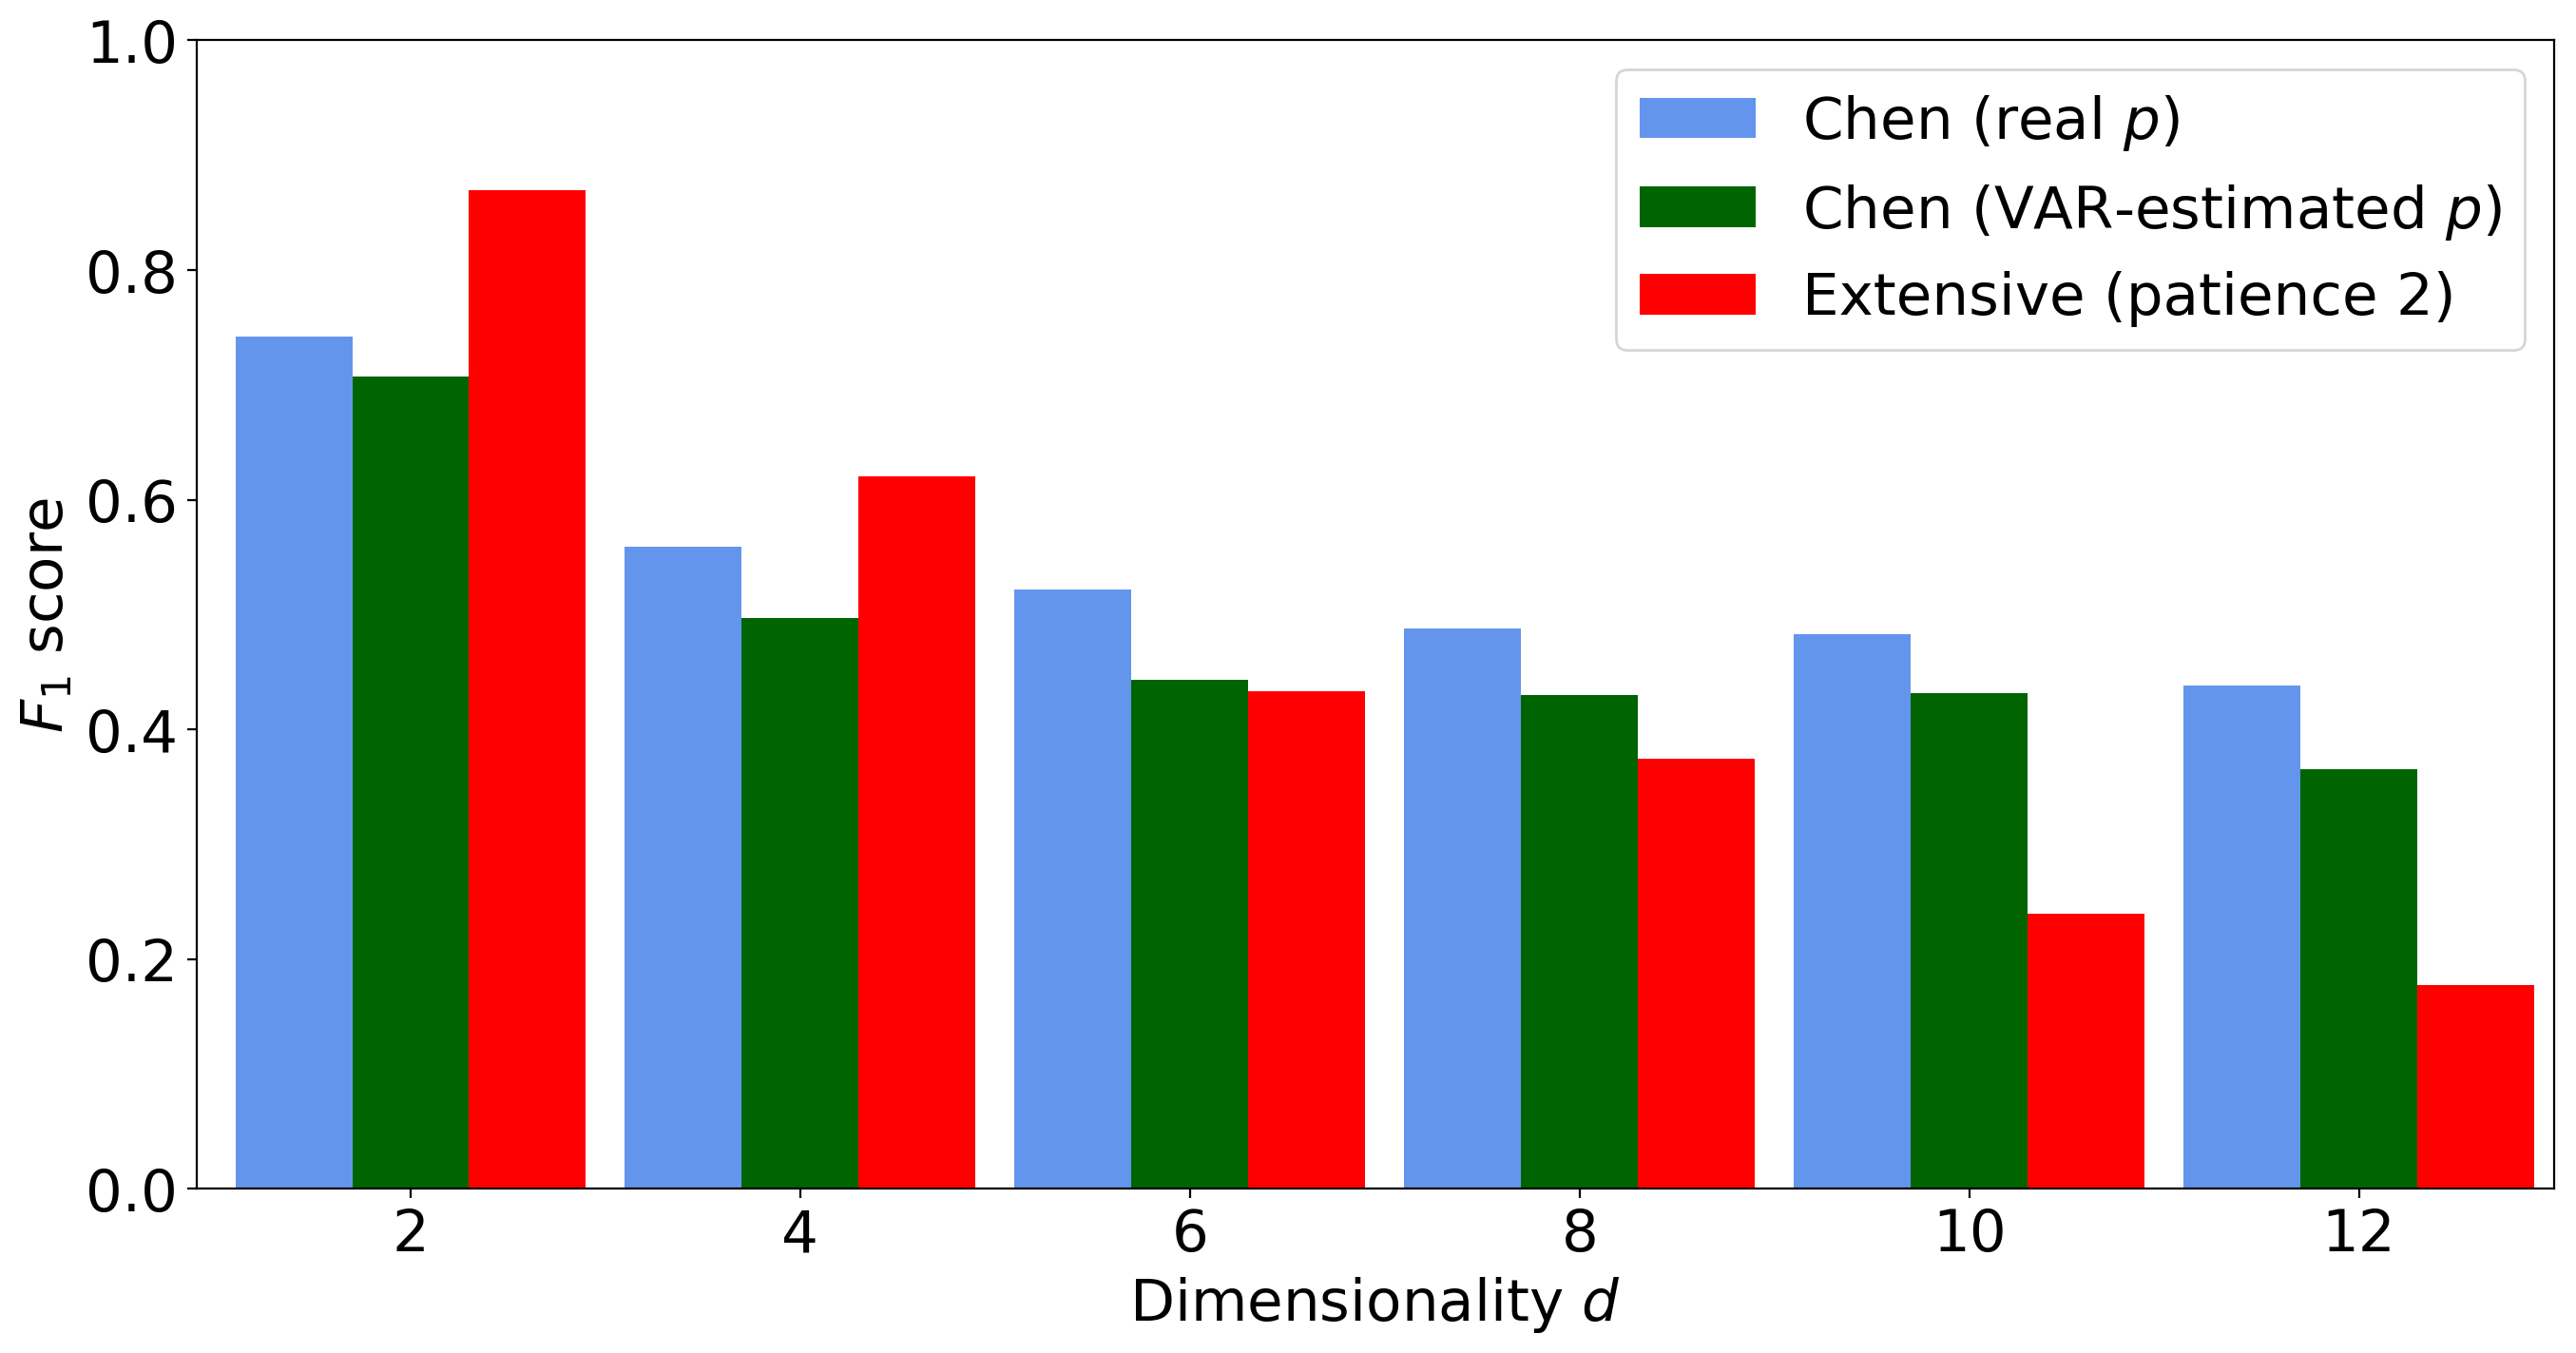

In [18]:
dims = np.arange(2,14,2)
approaches = {
    r'Chen (real $p$)': (0, 'cornflowerblue', comp_results_dim[comp_results_dim['method']=='real'].groupby('dimensions')['f1'].mean(), ''),
    r'Chen (VAR-estimated $p$)': (1, 'darkgreen', comp_results_dim[comp_results_dim['method']=='bic'].groupby('dimensions')['f1'].mean(), ''),
    'Extensive (patience 2)': (2, 'red', select_best_dim(results_dim, 'extensive', 2).groupby('dimensions')['f1'].mean(), '')
}

width=0.3
margin=0.1
plt.figure(dpi=200, figsize=(16,8))
# plt.title(r'$F_1$ score comparison', fontsize=22)
plt.xlabel(r'Dimensionality $d$', fontsize=22)
plt.ylabel(r'$F_1$ score', fontsize=22)
for name, (index, color, values, hatch) in approaches.items():
#    values = values[:len(dims)]
    plt.bar(np.arange(len(dims)) + index*width, values, width=width, label=f'{name}', color=color, hatch=hatch)

plt.xticks(np.arange(len(dims))+0.3, dims, fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(-0.5*width-margin, len(dims)-1*width+margin)
plt.ylim(0,1)
plt.legend(loc=1, fontsize=22)
plt.show()

### Runtime: dimensions

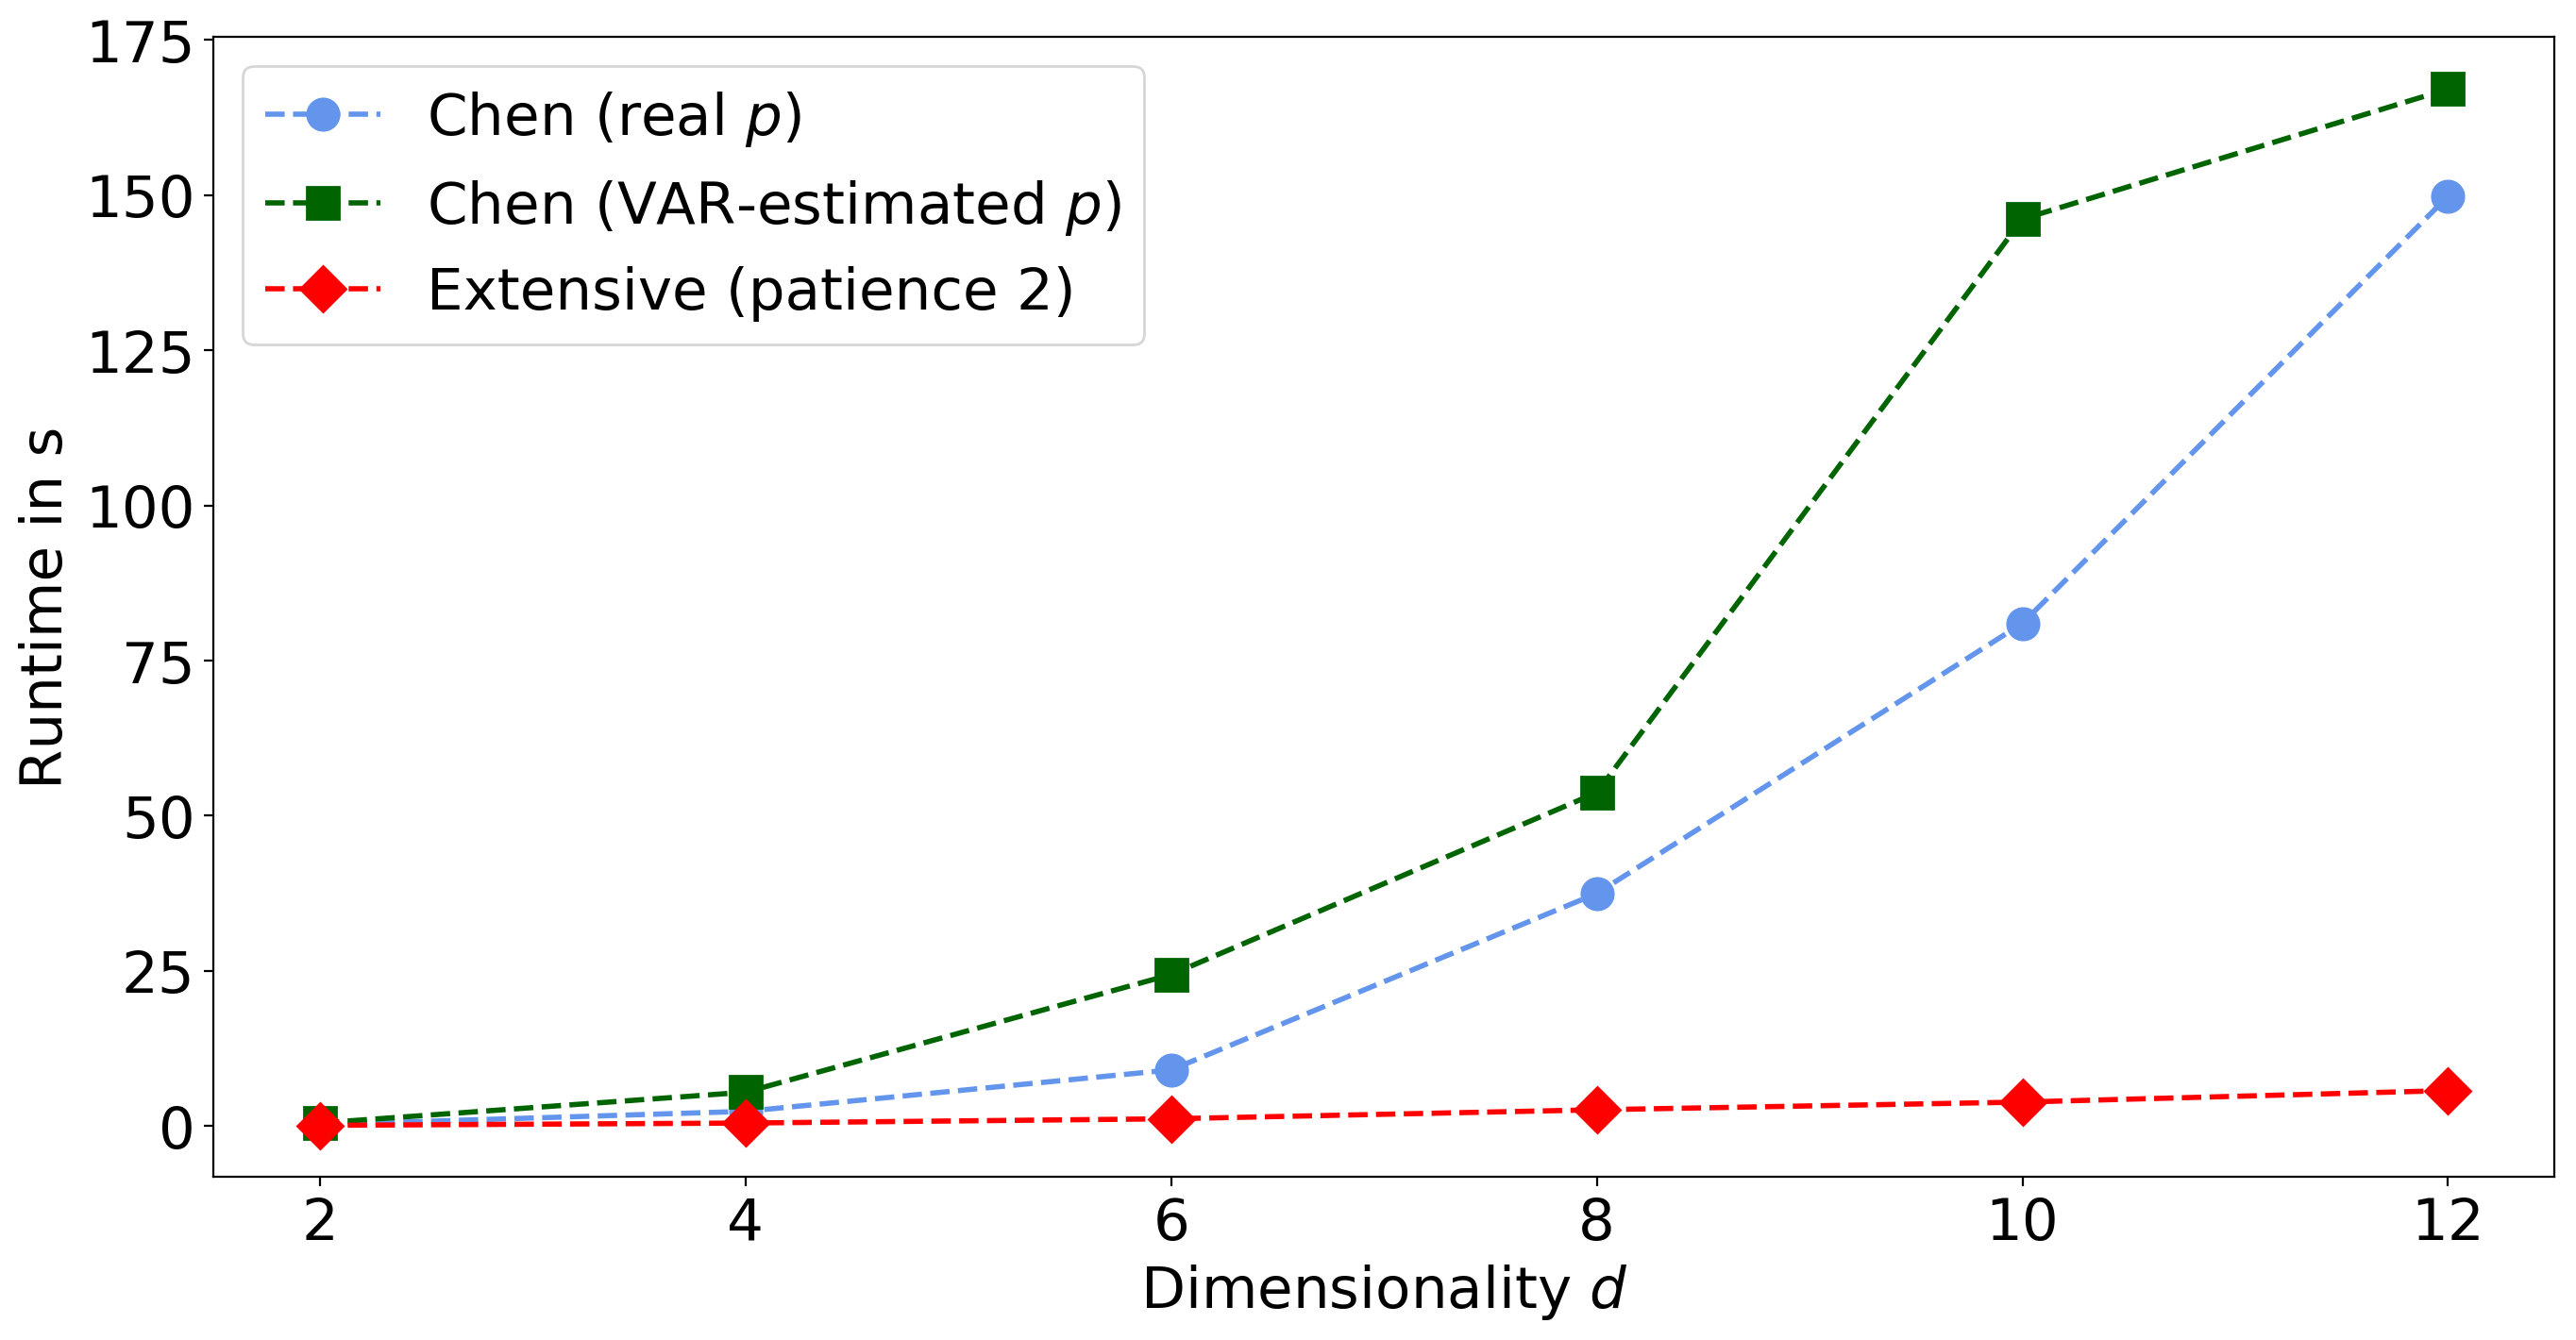

In [19]:
mean_runtime = {r'Chen (real $p$)': ('cornflowerblue', 
                                  comp_results_dim[comp_results_dim['method']=='real'].groupby(['dimensions'])['time'].mean(),
                                  'o', '--'),
                r'Chen (VAR-estimated $p$)': ('darkgreen', 
                                           comp_results_dim[comp_results_dim['method']=='bic'].groupby(['dimensions'])['time'].mean(),
                                           's', '--'),
                'Extensive (patience 2)': ('red', 
                                           results_runtime_dim(results_dim, 'extensive', 2).groupby(['dimensions'])['runtime'].mean(),
                                           'D', '--')
}


plt.figure(dpi=200, figsize=(16,8))

for name, (color, data, marker, linestyle) in mean_runtime.items():
    plt.plot(data.index, data, color=color, marker=marker, linestyle=linestyle, 
             label=name, linewidth=2, markersize=12)

plt.yscale('linear')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.title('Runtime for different dimensionality d', fontsize=22)
plt.xlabel(r'Dimensionality $d$', fontsize=22)
plt.ylabel('Runtime in s', fontsize=22)
plt.legend(fontsize=22)
plt.show()

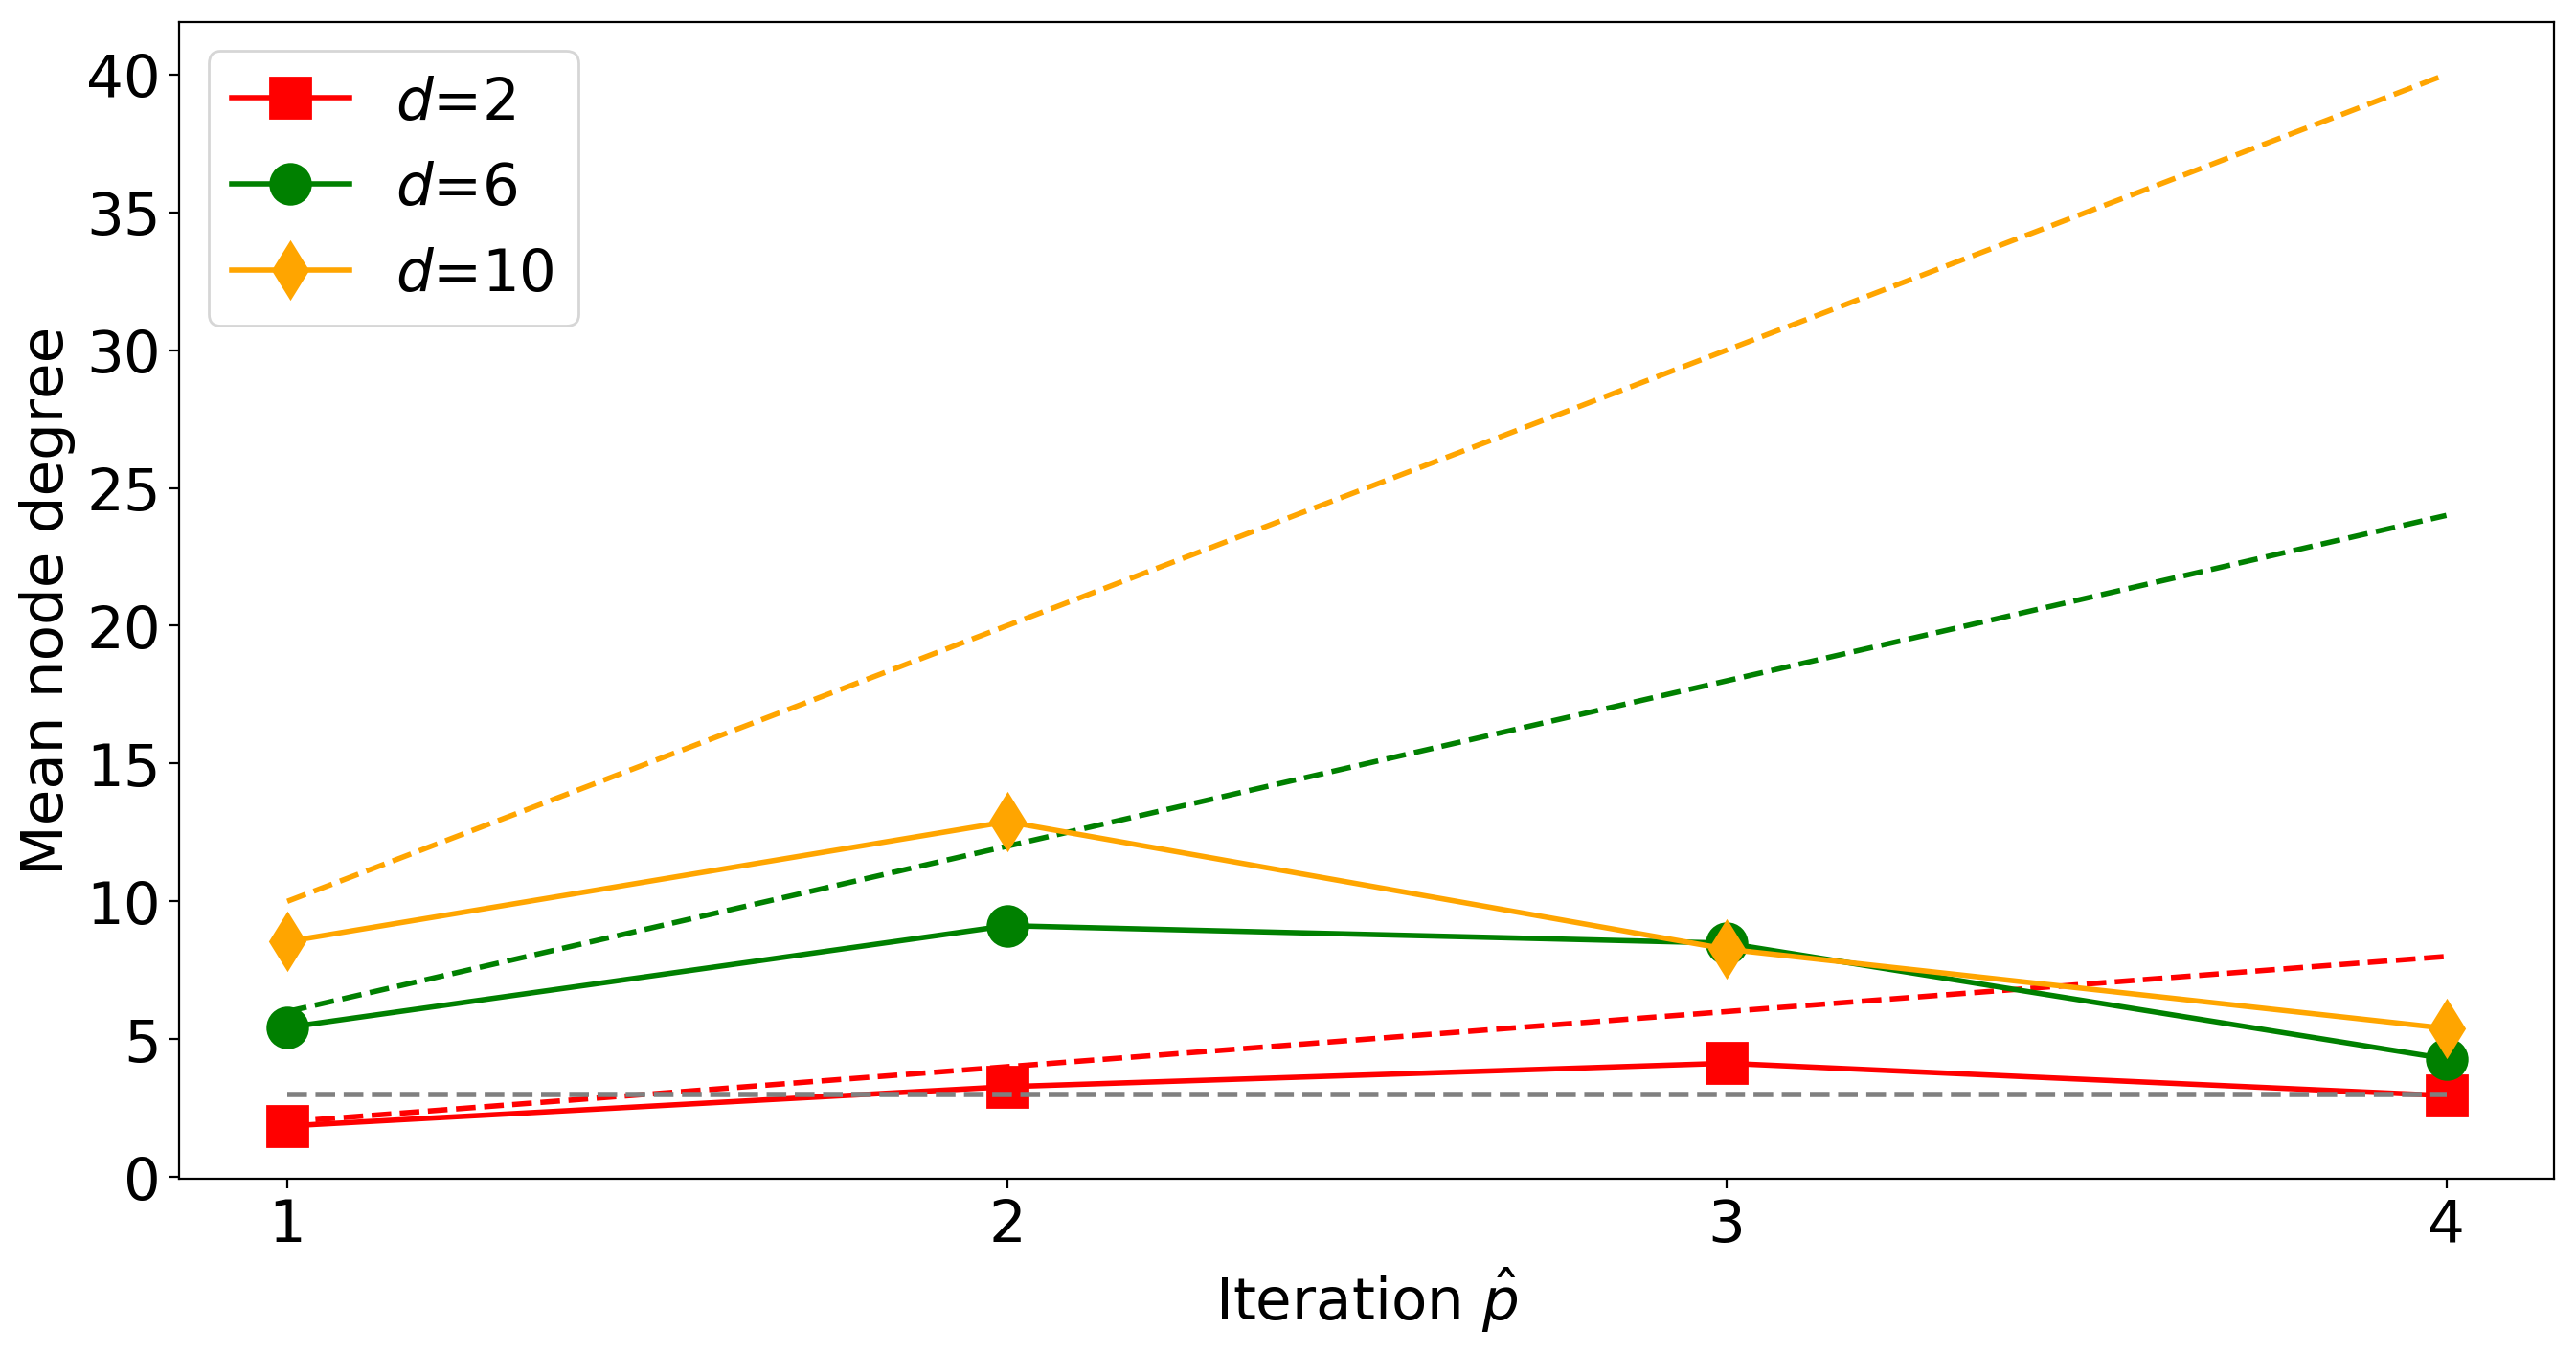

In [20]:
max_dim = 10
neighbors = pd.read_csv('results/iterations/neighborhoods_dimensions.csv')
selection = (neighbors['method']=='extensive')&(neighbors['dimensions'] <= max_dim)&(4 >= neighbors['iteration p'])
agg_neighbors = neighbors[selection].groupby(['dimensions', 'iteration p'])['neighbors mean'].mean().reset_index()

mean_degrees = {r'$d$=2': (agg_neighbors.loc[agg_neighbors['dimensions']==2, 'iteration p'],
                        agg_neighbors.loc[agg_neighbors['dimensions']==2, 'neighbors mean'],
                        'red', 's', 2),
               r'$d$=6': (agg_neighbors.loc[agg_neighbors['dimensions']==6, 'iteration p'],
                       agg_neighbors.loc[agg_neighbors['dimensions']==6, 'neighbors mean'],
                       'green', 'o', 6),
               r'$d$=10': (agg_neighbors.loc[agg_neighbors['dimensions']==10, 'iteration p'],
                        agg_neighbors.loc[agg_neighbors['dimensions']==10, 'neighbors mean'],
                       'orange', 'd', 10)
                
    
}


plt.figure(dpi=200, figsize=(16, 8))
for name, (x, y, color, marker, d) in mean_degrees.items():
    plt.plot(x, y, label=name, color=color, marker=marker, linewidth=2, markersize=15)
    plt.plot(np.arange(1, 4+1), np.arange(1, 4+1)*d, color=color, linestyle='--', linewidth=2)

plt.xlabel(r'Iteration $\hat{p}$', fontsize=22)
plt.ylabel('Mean node degree', fontsize=22)
# plt.title('Mean degree for different dimensionality d', fontsize=22)
plt.xticks(np.arange(1, 5, 1), np.arange(1, 5, 1), fontsize=22)
plt.yticks(fontsize=22)
plt.plot(np.arange(1, 4+1), np.full(4, 3), c='grey', linestyle='--', linewidth=2)  
plt.legend(fontsize=22)
plt.show()